In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

# In this project, always use fstring for formatting, which requires Python 3.6+

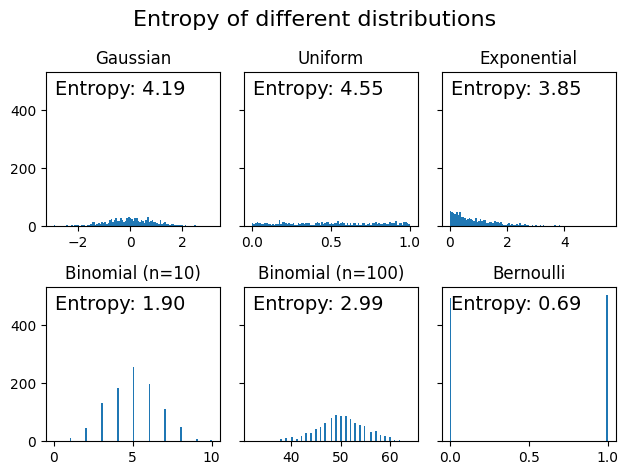

In [2]:
# Generate multiple distributions
n_samples = 1000
gaussian_dist = np.random.normal(0, 1, n_samples)
uniform_dist = np.random.uniform(0, 1, n_samples)
exponential_dist = np.random.exponential(1, n_samples)
binomial_trial_10_dist = np.random.binomial(10, 0.5, n_samples)
binomial_trial_100_dist = np.random.binomial(100, 0.5, n_samples)
bernoulli_dist = np.random.binomial(1, 0.5, n_samples)

# plot these distributions, obtain the histogram
n_bins = 100
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
hist_gaussian = axs[0, 0].hist(gaussian_dist, bins=n_bins)[0]
axs[0, 0].set_title('Gaussian')
hist_uniform = axs[0, 1].hist(uniform_dist, bins=n_bins)[0]
axs[0, 1].set_title('Uniform')
hist_exponential = axs[0, 2].hist(exponential_dist, bins=n_bins)[0]
axs[0, 2].set_title('Exponential')
hist_binomial_trial_10 = axs[1, 0].hist(binomial_trial_10_dist, bins=n_bins)[0]
axs[1, 0].set_title('Binomial (n=10)')
hist_binomial_trial_100 = axs[1, 1].hist(binomial_trial_100_dist, bins=n_bins)[0]
axs[1, 1].set_title('Binomial (n=100)')
hist_bernoulli = axs[1, 2].hist(bernoulli_dist, bins=n_bins)[0]
axs[1, 2].set_title('Bernoulli')

# Calculate entropy for each distribution
gaussian_entropy = entropy(hist_gaussian)
uniform_entropy = entropy(hist_uniform)
exponential_entropy = entropy(hist_exponential)
binomial_trial_10_entropy = entropy(hist_binomial_trial_10)
binomial_trial_100_entropy = entropy(hist_binomial_trial_100)
bernoulli_entropy = entropy(hist_bernoulli)

axs[0, 0].text(0.05, 0.95, 'Entropy: {:.2f}'.format(gaussian_entropy), transform=axs[0, 0].transAxes, fontsize=14, verticalalignment='top')
axs[0, 1].text(0.05, 0.95, 'Entropy: {:.2f}'.format(uniform_entropy), transform=axs[0, 1].transAxes, fontsize=14, verticalalignment='top')
axs[0, 2].text(0.05, 0.95, 'Entropy: {:.2f}'.format(exponential_entropy), transform=axs[0, 2].transAxes, fontsize=14, verticalalignment='top')
axs[1, 0].text(0.05, 0.95, 'Entropy: {:.2f}'.format(binomial_trial_10_entropy), transform=axs[1, 0].transAxes, fontsize=14, verticalalignment='top')
axs[1, 1].text(0.05, 0.95, 'Entropy: {:.2f}'.format(binomial_trial_100_entropy), transform=axs[1, 1].transAxes, fontsize=14, verticalalignment='top')
axs[1, 2].text(0.05, 0.95, 'Entropy: {:.2f}'.format(bernoulli_entropy), transform=axs[1, 2].transAxes, fontsize=14, verticalalignment='top')
fig.suptitle('Entropy of different distributions', fontsize=16)

plt.show()

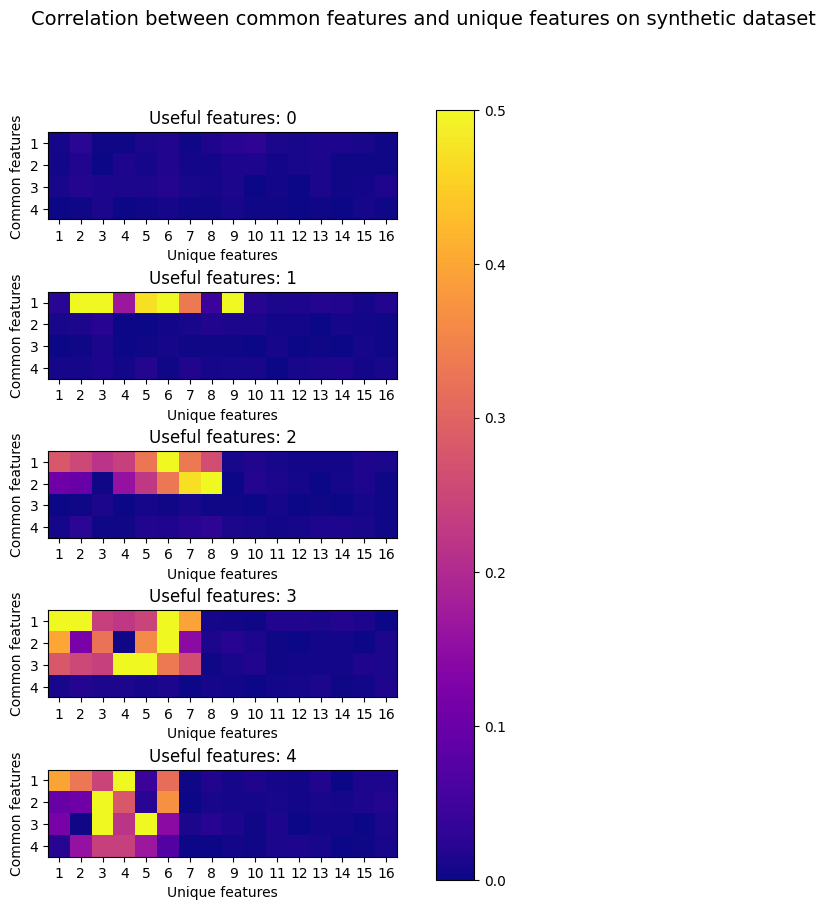

In [3]:
# In this project, always use fstring for formatting, which requires Python 3.6+
# Test correlation on synthetic data
# generate a dataset
n_samples = 10000
n_features = 20
n_informative = 5
n_redundant = 5
seed = 0
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, shuffle=False, random_state=seed)
useful_X = X[:, :n_informative + n_redundant]
noise_X = X[:, n_informative + n_redundant:]

corr_summary = []
n_common_features = 4


for n_useful_features in range(min(n_common_features + 1, n_informative + n_redundant + 1)):
    n_noise_features = n_common_features - n_useful_features
    assert n_noise_features >= 0
    # random draw common features with n_useful_features useful features and n_noise_features noise features
    common_feature_ids_useful = np.random.choice(useful_X.shape[1], n_useful_features, replace=False)
    common_feature_ids_noise = np.random.choice(noise_X.shape[1], n_noise_features, replace=False)
    common_features = np.concatenate((useful_X[:, common_feature_ids_useful], noise_X[:, common_feature_ids_noise]), axis=1)
    unique_features = np.concatenate([np.delete(useful_X, common_feature_ids_useful, axis=1), np.delete(noise_X, common_feature_ids_noise, axis=1)], axis=1)

    # check the size
    assert common_features.shape[0] == unique_features.shape[0] == n_samples
    assert common_features.shape[1] == n_common_features
    assert unique_features.shape[1] == n_features - n_common_features

    # normalize both common and unique features
    common_features = (common_features - common_features.mean(axis=0)) / common_features.std(axis=0)
    unique_features = (unique_features - unique_features.mean(axis=0)) / unique_features.std(axis=0)

    assert common_features.shape[1] <= unique_features.shape[1]
    # perform PCA on unique features to the same dimension as common features
    pca = PCA(n_components=n_common_features)
    unique_features_low_dim = pca.fit_transform(unique_features)

    # plot the column-wise correlation between common features and unique features in heatmap
    common_features_df = pd.DataFrame(common_features)
    unique_features_df = pd.DataFrame(unique_features)
    corr_all = pd.concat([common_features_df, unique_features_df], axis=1).corr()
    corr = corr_all.iloc[:n_common_features, n_common_features:]

    corr_summary.append(np.abs(corr))

# plot the heatmap of all correlation matrices
fig, axs = plt.subplots(len(corr_summary), 1, figsize=(10, 10))
# print min and max value in corr
min_corr = 0
max_corr = 0.5
fig.suptitle(f'Correlation between common features and unique features on synthetic dataset', fontsize=14)
for i, corr in enumerate(corr_summary):
    axs[i].imshow(corr, vmin=min_corr, vmax=max_corr, cmap='plasma')
    axs[i].set_title(f'Useful features: {i}')
    axs[i].set_xticks(np.arange(n_features - n_common_features))
    axs[i].set_xticklabels(np.arange(n_features - n_common_features) + 1)
    axs[i].set_yticks(np.arange(n_common_features))
    axs[i].set_yticklabels(np.arange(n_common_features) + 1)
    axs[i].set_xlabel('Unique features')
    axs[i].set_ylabel('Common features')
plt.colorbar(axs[0].images[0], ax=axs, fraction=0.5, pad=0.05)
plt.show()



In [23]:
# In this project, always use fstring for formatting, which requires Python 3.6+

# load house dataset
beijing_root = 'data/beijing/'
house_df = pd.read_csv(os.path.join(beijing_root, 'house_clean.csv'))
airbnb_df = pd.read_csv(os.path.join(beijing_root, 'airbnb_clean.csv'))
print(house_df.columns)
print(airbnb_df.columns)

Index(['lon', 'lat', 'cid', 'DOM', 'followers', 'totalPrice', 'square',
       'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor',
       'constructionTime', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'did_2', 'did_3', 'did_4', 'did_5', 'did_6', 'did_7', 'did_8',
       'did_9', 'did_10', 'did_11', 'did_12', 'did_13', 'bt_2', 'bt_3', 'bt_4',
       'rc_2', 'rc_3', 'rc_4', 'bs_2', 'bs_3', 'bs_4', 'bs_5', 'bs_6',
       'ty_2014', 'ty_2015', 'ty_2016', 'ty_2017', 'ty_2018', 'tm_2', 'tm_3',
       'tm_4', 'tm_5', 'tm_6', 'tm_7', 'tm_8', 'tm_9', 'tm_10', 'tm_11',
       'tm_12'],
      dtype='object')
Index(['lat', 'lon', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'nbr_丰台区 ', 'nbr_大兴区 ', 'nbr_密云县 ', 'nbr_平谷区 ',
       'nbr_延庆县 ', 'nbr_怀柔区 ', 'nbr_房山区', 'nbr_昌平区', 'nbr_朝阳区 ', 'nbr_海淀区',
       'nbr_石景山区', 'nbr_西城区', 'nbr_通州区 ', 'nbr_门头沟区 ', 'nbr_顺义区 ',
       'rt_Priv

In [22]:
# In this project, always use fstring for formatting, which requires Python 3.6+

# load house dataset
game_root = 'data/game/'
steam_df = pd.read_csv(os.path.join(game_root, 'steam_clean.csv'))
rawg_df = pd.read_csv(os.path.join(game_root, 'rawg_clean.csv'))
print(steam_df.columns)
print(rawg_df.columns)

Index(['name', 'english', 'required_age', 'achievements', 'positive_ratings',
       'negative_ratings', 'average_playtime', 'median_playtime', 'owners',
       'price',
       ...
       'gn_Violent;Indie;RPG', 'gn_Violent;Indie;Strategy;Early Access',
       'gn_Violent;RPG', 'gn_Violent;RPG;Strategy', 'gn_Violent;Simulation',
       'gn_Violent;Simulation;Early Access', 'gn_Violent;Simulation;Sports',
       'gn_Violent;Sports', 'gn_Violent;Strategy', 'gn_Web Publishing'],
      dtype='object', length=1598)
Index(['name', 'rating', 'playtime', 'achievements_count', 'suggestions_count',
       'game_series_count', 'reviews_count', 'added_status_yet',
       'added_status_owned', 'added_status_beaten', 'added_status_toplay',
       'added_status_dropped', 'added_status_playing', 'has_website',
       'released_year_before_2020', 'updated_year_before_2020', '3DO',
       'Android', 'Apple II', 'Atari 2600', 'Atari 5200', 'Atari 7800',
       'Atari 8-bit', 'Atari Flashback', 'Atari Lyn

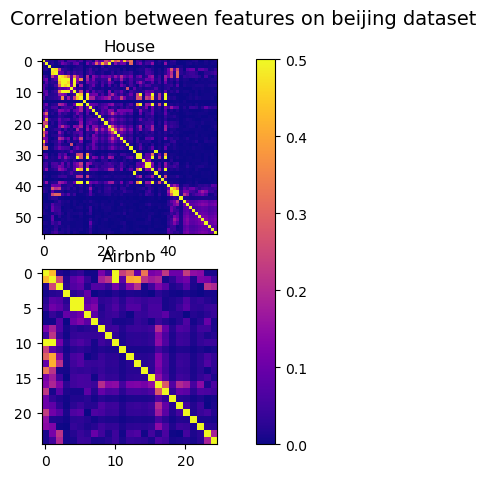

In [17]:
# Test correlation on real data
# get 'lon' and 'lat' as common features
house_common_features = house_df[['lon', 'lat']]
house_unique_features = house_df.drop(['lon', 'lat'], axis=1)
airbnb_common_features = airbnb_df[['lon', 'lat']]
airbnb_unique_features = airbnb_df.drop(['lon', 'lat'], axis=1)

# calculate column-wise correlation
corr_house = pd.concat([house_common_features, house_unique_features], axis=1).corr()#.iloc[:2, 2:]
corr_airbnb = pd.concat([airbnb_common_features, airbnb_unique_features], axis=1).corr()#.iloc[:2, 2:]

# plot the heatmap of correlation
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
fig.suptitle(f'Correlation between features on beijing dataset', fontsize=14)
axs[0].imshow(np.abs(corr_house), vmin=0, vmax=0.5, cmap='plasma')
axs[0].set_title(f'House')
# axs[0].set_xlabel('Unique features')
# axs[0].set_ylabel('Common features')
axs[1].imshow(np.abs(corr_airbnb), vmin=0, vmax=0.5, cmap='plasma')
axs[1].set_title(f'Airbnb')
# axs[1].set_xlabel('Unique features')
# axs[1].set_ylabel('Common features')
plt.colorbar(axs[0].images[0], ax=axs, fraction=0.5, pad=0.05)
plt.show()


In [28]:
# calculate the entropy of each column
house_y = house_df['totalPrice']
house_x = house_df.drop(['totalPrice'], axis=1)
feat_entropy = house_x.apply(lambda x: entropy(x.value_counts(normalize=True)), axis=0)
feat_entropy.sort_values(ascending=False, inplace=True)
print(feat_entropy)



square               8.964820
cid                  7.527922
lat                  7.520988
lon                  7.518066
followers            4.214554
DOM                  3.581968
constructionTime     3.507812
floor                2.714602
ladderRatio          2.336656
livingRoom           1.096896
drawingRoom          0.727189
rc_4                 0.691166
bt_4                 0.686865
ty_2016              0.686071
elevator             0.684272
bs_6                 0.680322
subway               0.675401
fiveYearsProperty    0.664182
bs_2                 0.661723
rc_3                 0.637757
did_7                0.635394
ty_2017              0.594666
ty_2015              0.488920
bt_3                 0.478299
bathRoom             0.465576
did_6                0.378405
tm_8                 0.370820
tm_3                 0.360893
did_8                0.348342
tm_9                 0.340943
did_2                0.321595
tm_7                 0.318949
tm_12                0.318285
did_10    

In [15]:
house_common_1 = house_df[['lon', 'lat']]
house_common_2 = house_df[['lon', 'lat', 'cid']]
house_common_3 = house_df[['cid']]

# scale house_y
house_y = house_y / house_y.max()

# use three common features to predict y with linear classification, report the MSE
lr1 = sklearn.linear_model.LinearRegression()
lr1.fit(house_common_1, house_y)
print(f'Linear regression with common features 1: {sklearn.metrics.mean_squared_error(house_y, lr1.predict(house_common_1))}')
lr2 = sklearn.linear_model.LinearRegression()
lr2.fit(house_common_2, house_y)
print(f'Linear regression with common features 2: {sklearn.metrics.mean_squared_error(house_y, lr2.predict(house_common_2))}')
lr3 = sklearn.linear_model.LinearRegression()
lr3.fit(house_common_3, house_y)
print(f'Linear regression with common features 3: {sklearn.metrics.mean_squared_error(house_y, lr3.predict(house_common_3))}')


Linear regression with common features 1: 0.03348769536855392
Linear regression with common features 2: 0.03348769533508471
Linear regression with common features 3: 0.033578565531134245


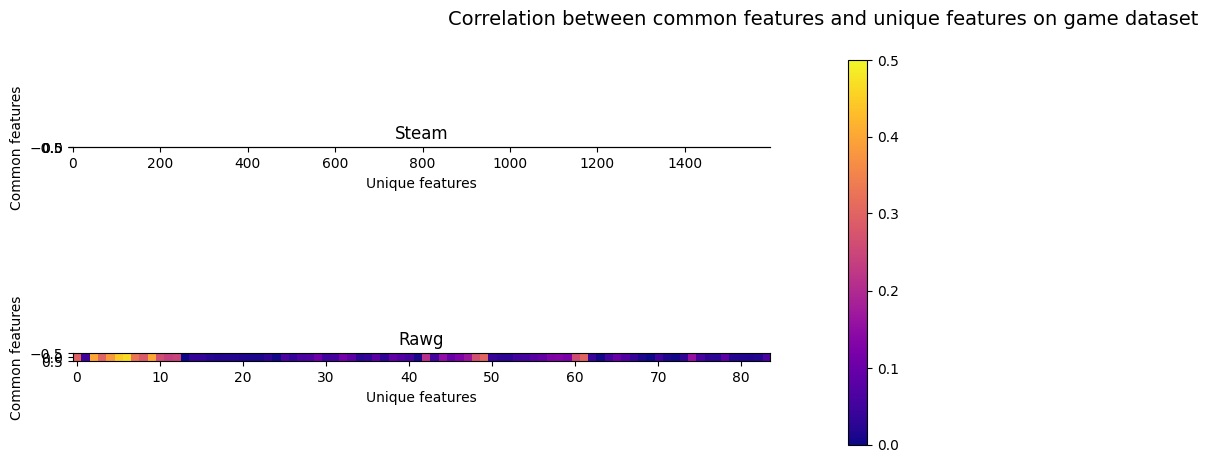

In [84]:
# Test correlation on game data
# get 'lon' and 'lat' as common features
steam_common_features = steam_df[['name']]
steam_unique_features = steam_df.drop(['name'], axis=1)
rawg_common_features = rawg_df[['name']]
rawg_unique_features = rawg_df.drop(['name'], axis=1)

# calculate column-wise correlation
corr_steam = pd.concat([steam_common_features, steam_unique_features], axis=1).corr(numeric_only=True).iloc[:1, 1:]
corr_rawg = pd.concat([rawg_common_features, rawg_unique_features], axis=1).corr(numeric_only=True).iloc[:1, 1:]

# plot the heatmap of correlation
fig, axs = plt.subplots(2, 1, figsize=(20, 5))
fig.suptitle(f'Correlation between common features and unique features on game dataset', fontsize=14)
axs[0].imshow(np.abs(corr_steam), vmin=0, vmax=0.5, cmap='plasma')
axs[0].set_title(f'Steam')
axs[0].set_xlabel('Unique features')
axs[0].set_ylabel('Common features')
axs[1].imshow(np.abs(corr_rawg), vmin=0, vmax=0.5, cmap='plasma')
axs[1].set_title(f'Rawg')
axs[1].set_xlabel('Unique features')
axs[1].set_ylabel('Common features')
plt.colorbar(axs[0].images[0], ax=axs, fraction=0.5, pad=0.05)plt.show()

In [14]:
from cachetools import cached, LRUCache

# test if cache works for method
class A:
    def key(self, x, y):
        return hash(x)

    @cached(cache=LRUCache(maxsize=2), key=key)
    def test(self, x, y):
        print(f'test {x} {y}')
        return x


a = A()
a.test(1, 2)
a.test(1, 2)
a.test(1, 3)


test 1 2


1

In [25]:
a = [0.44898978, 0.24207652, 0.15326022]
print(f"a: {a[0]/(a[0]+a[1]+a[2])}, {a[1]/(a[0]+a[1]+a[2])}, {a[2]/(a[0]+a[1]+a[2])}")

a: 0.5317726843401768, 0.28670960139923113, 0.18151771426059196


In [23]:
print(f"{3/6}, {2/6}, {1/6}")

0.5, 0.3333333333333333, 0.16666666666666666


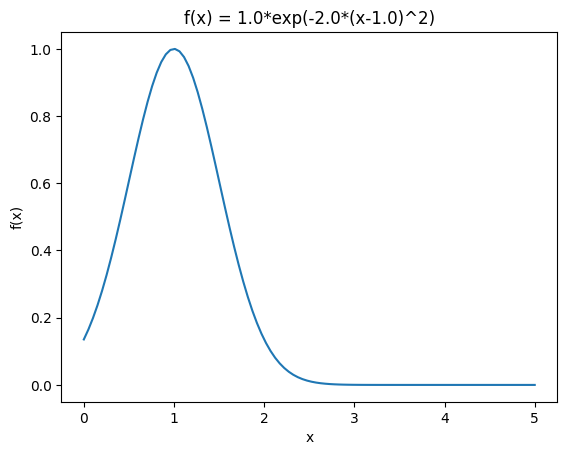

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x, t, a):
    return t * np.exp(-a * (x - t)**2)

# Define the values of t and a
t = 1.0
a = 2.0

# Define the range of x values
x = np.linspace(0, 5, 100)

# Calculate the corresponding y values
y = f(x, t, a)

# Plot the curve
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'f(x) = {t}*exp(-{a}*(x-{t})^2)')
plt.show()
